In [1]:
# Python > 3, TensorFlow > 1.0
# Import core TensorFlow modules
import tensorflow as tf
import numpy as np

In [2]:
# Modules required for file download and extraction
import os
import sys
import tarfile
from six.moves.urllib.request import urlretrieve
from scipy import ndimage

# It's notMNIST! Don't worry, we won't be here for long.

In [3]:
# Directory to download dataset
DATASET_DIR = 'data/notmnist/'

# Directory to save TensorBoard summary statistics, graph data, etc
TB_DIR = 'tensorboard/feedforward'

if not os.path.exists(DATASET_DIR):
    os.mkdir(DATASET_DIR)

In [4]:
def maybe_download(filename, url, force=False):
    """Download a file if not present."""
    if force or not os.path.exists(DATASET_DIR + filename):
        filename, _ = urlretrieve(url + filename, DATASET_DIR + filename)
        print('\nDownload complete for {}'.format(filename))
        return filename
    else:
        print('File {} already present.'.format(filename))
    return DATASET_DIR + filename

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('{} already present - don\'t need to extract {}.'.format(root, filename))
    else:
        print('Extracting data for {}. This may take a while. Please wait.'.format(root))
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(root[0:root.rfind('/') + 1])
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    print(data_folders)
    return data_folders

In [5]:
# Locations to download data:
url = 'http://yaroslavvb.com/upload/notMNIST/'

In [6]:
# Download notMNIST small dataset
train_zip_path = maybe_download('notMNIST_small.tar.gz', url)

File notMNIST_small.tar.gz already present.


In [7]:
# Extract datasets
train_folders = maybe_extract(train_zip_path)

data/notmnist/notMNIST_small already present - don't need to extract data/notmnist/notMNIST_small.tar.gz.
['data/notmnist/notMNIST_small/A', 'data/notmnist/notMNIST_small/B', 'data/notmnist/notMNIST_small/C', 'data/notmnist/notMNIST_small/D', 'data/notmnist/notMNIST_small/E', 'data/notmnist/notMNIST_small/F', 'data/notmnist/notMNIST_small/G', 'data/notmnist/notMNIST_small/H', 'data/notmnist/notMNIST_small/I', 'data/notmnist/notMNIST_small/J']


In [8]:
len(train_folders)

10

# Load in the data

In [9]:
image_height = 28  # Pixel height of images
image_width = 28  # Pixel width of images
pixel_depth = 255.0  # Number of levels per pixel
expected_img_shape = (image_height, image_width)  # Black and white image, no 3rd dimension
num_labels = len(train_folders)

def load_image_folder(folder):
    """Load the data for a single image label."""

    # Create a list of image paths inside the folder  
    image_files = os.listdir(folder)
    # Create empty numpy array to hold data
    dataset = np.ndarray(shape=(len(image_files), image_height, image_width),
                         dtype=np.float32)
    num_images = 0  # Counter for number of successful images loaded
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            # Read in image pixel data as floating point values
            image_data = ndimage.imread(image_file).astype(float)
            # Scale values: [0.0, 255.0] => [-1.0, 1.0] 
            image_data = (image_data - pixel_depth / 2) / (pixel_depth / 2)
            if image_data.shape != expected_img_shape:
                print('File {} has unexpected dimensions: '.format(str(image_data.shape)))
                continue
            # Add image to the numpy array dataset
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- skipping this file and moving on.')
  
    # Trim dataset to remove unused space
    dataset = dataset[0:num_images, :, :]
    return dataset

In [10]:
def make_data_label_arrays(num_rows, image_height, image_width):
    """
    Creates and returns empty numpy arrays for input data and labels
    """
    if num_rows:
        dataset = np.ndarray((num_rows, image_height, image_width), dtype=np.float32)
        labels = np.ndarray(num_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def collect_datasets(data_folders):
    datasets = []
    total_images = 0
    for label, data_folder in enumerate(data_folders):
        # Bring all test folder images in as numpy arrays
        dataset = load_image_folder(data_folder)
        num_images = len(dataset)
        total_images += num_images
        datasets.append((dataset, label, num_images))
    return datasets, total_images

def merge_train_test_datasets(datasets, total_images, percent_test):
    num_train = int(total_images * (1.0 - percent_test))
    num_test = int(total_images * percent_test)
    train_dataset, train_labels = make_data_label_arrays(num_train, image_height, image_width)
    test_dataset, test_labels = make_data_label_arrays(num_test, image_height, image_width)
    
    train_counter = 0
    test_counter = 0
    dataset_counter = 1
    for dataset, label, num_images in datasets:
        np.random.shuffle(dataset)
        if dataset_counter != len(datasets):
            n_v = int(num_images // (1.0 / percent_test))
            n_t = num_images - n_v
        else:
            # Last label, make sure dataset sizes match up to what we created
            n_v = len(test_dataset) - test_counter
            n_t = len(train_dataset) - train_counter
        train_dataset[train_counter: train_counter + n_t] = dataset[:n_t]
        train_labels[train_counter: train_counter + n_t] = label
        test_dataset[test_counter: test_counter + n_v] = dataset[n_t: n_t + n_v]
        test_labels[test_counter: test_counter + n_v] = label
        train_counter += n_t
        test_counter += n_v
        dataset_counter += 1
    return train_dataset, train_labels, test_dataset, test_labels

In [11]:
train_test_datasets, train_test_total_images = collect_datasets(train_folders)

Could not read: data/notmnist/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file 'data/notmnist/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - skipping this file and moving on.
Could not read: data/notmnist/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file 'data/notmnist/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - skipping this file and moving on.


In [12]:
train_dataset, train_labels, test_dataset, test_labels = \
  merge_train_test_datasets(train_test_datasets, train_test_total_images, 0.1)

In [13]:
len(train_dataset)

16851

# Convert (height, width, channels) to vector

```
Previous example shape:
(10, 10, 3)

New vector:
[300]
```

# Convert integer label with one-hot vector

```
Previous label:
4

New one-hot vector (assuming 10 labels)
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
```

In [14]:
# Convert data examples flattened vectors
# Convert labels to one-hot encoding
num_channels = 1  # grayscale
def reformat(dataset, labels):
    dataset = dataset.reshape( (-1, image_height * image_width)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

In [15]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

In [16]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (16851, 784) (16851, 10)
Test set (1872, 784) (1872, 10)


# Shuffle data/labels in unison

In [17]:
def shuffle_data_with_labels(dataset, labels):
    indices = range(len(dataset))
    np.random.shuffle(np.copy(indices))
    new_data = np.ndarray(dataset.shape, dataset.dtype)
    new_labels = np.ndarray(labels.shape, dataset.dtype)
    n = 0
    for i in indices:
        new_data[n] = dataset[i]
        new_labels[n] = labels[i]
        n += 1
    return new_data, new_labels

In [18]:
train_dataset, train_labels = shuffle_data_with_labels(train_dataset, train_labels)

# Actually create our model!

In [19]:
batch_size = 64

num_hidden_1 = 300
num_hidden_2 = 150
num_hidden_3 = 50

# Input data.
input_data = tf.placeholder(tf.float32, shape=(None, image_height * image_width), name="input_data")
input_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name="input_labels")
  
with tf.name_scope('hidden1'):
    weights = tf.Variable(tf.truncated_normal([image_height * image_width, num_hidden_1]), name='weights')
    biases = tf.Variable(tf.zeros([num_hidden_1]), name='biases')
    hidden1 = tf.nn.sigmoid(tf.matmul(input_data, weights) + biases)

with tf.name_scope('hidden2'):
    weights = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2]), name='weights')
    biases = tf.Variable(tf.zeros([num_hidden_2]), name='biases')
    hidden2 = tf.nn.sigmoid(tf.matmul(hidden1, weights) + biases)

with tf.name_scope('hidden3'):
    weights = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3]), name='weights')
    biases = tf.Variable(tf.zeros([num_hidden_3]), name='biases')
    hidden3 = tf.nn.sigmoid(tf.matmul(hidden2, weights) + biases)

with tf.name_scope('output_layer'):
    weights = tf.Variable(tf.truncated_normal([num_hidden_3, num_labels]), name='weights')
    biases = tf.Variable(tf.zeros([num_labels]), name='biases')
    logits = tf.matmul(hidden3, weights) + biases

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_labels))
    
# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
# Predictions for the training and test data.
model_prediction = tf.nn.softmax(logits, name="prediction")
label_prediction = tf.argmax(model_prediction, 1, name="predicted_label")
   
# Global step
global_step = tf.Variable(0, trainable=False, name='global_step')
inc_step = global_step.assign_add(1)

with tf.name_scope('summaries'):
# TF API change for v1.0 => summary.scalar: name must be python string, placeholders not allowed
#    summary_label = tf.placeholder(tf.string, []) 
#    tf.summary.scalar(tf.reduce_join([b'loss_', summary_label], 0),loss)
    tf.summary.scalar('loss',loss)
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(label_prediction, tf.argmax(input_labels, 1))
        model_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#        acc_summ = tf.summary.scalar(tf.reduce_join([b'accuracy_', summary_label], 0), model_accuracy)
        acc_summ = tf.summary.scalar('accuracy', model_accuracy)
    
merged_summaries = tf.summary.merge_all()
init = tf.global_variables_initializer()

# Now run the graph!

In [20]:
session = tf.Session()
writer = tf.summary.FileWriter(TB_DIR, graph=session.graph)

In [21]:
session.run(init)

In [22]:
num_steps = 3001
test_dict = {input_data : test_dataset, input_labels : test_labels}
             #summary_label: b'validation'}

for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {input_data : batch_data, input_labels : batch_labels}
#                 summary_label: b'training'}
    _, l, predictions, accuracy, summaries, g_step = session.run(
        [optimizer, loss, model_prediction, model_accuracy, merged_summaries, inc_step], feed_dict=feed_dict)
    if (g_step % 50 == 0):
        writer.add_summary(summaries, g_step)
        print('Minibatch loss at step %d: %f' % (g_step, l))
        print('Minibatch accuracy: {}'.format(accuracy))
    if (g_step % 200 == 0):
        accuracy, summaries = session.run([model_accuracy, merged_summaries], feed_dict=test_dict)
        writer.add_summary(summaries, g_step)
        print('Test accuracy: {}'.format(accuracy))
        

test_accuracy = session.run(model_accuracy, feed_dict=test_dict)
print('Test accuracy: {}'.format(test_accuracy))
writer.flush()

Minibatch loss at step 50: 0.033071
Minibatch accuracy: 1.0
Minibatch loss at step 100: 0.036841
Minibatch accuracy: 1.0
Minibatch loss at step 150: 0.086455
Minibatch accuracy: 0.96875
Minibatch loss at step 200: 0.082927
Minibatch accuracy: 1.0
Test accuracy: 0.10576923191547394
Minibatch loss at step 250: 0.104419
Minibatch accuracy: 1.0
Minibatch loss at step 300: 0.159961
Minibatch accuracy: 1.0
Minibatch loss at step 350: 0.280118
Minibatch accuracy: 0.921875
Minibatch loss at step 400: 0.514911
Minibatch accuracy: 0.875
Test accuracy: 0.11057692021131516
Minibatch loss at step 450: 2.073001
Minibatch accuracy: 0.28125
Minibatch loss at step 500: 4.284349
Minibatch accuracy: 0.3125
Minibatch loss at step 550: 0.036258
Minibatch accuracy: 1.0
Minibatch loss at step 600: 0.036082
Minibatch accuracy: 1.0
Test accuracy: 0.10630341619253159
Minibatch loss at step 650: 0.073983
Minibatch accuracy: 1.0
Minibatch loss at step 700: 0.089361
Minibatch accuracy: 0.984375
Minibatch loss at s

In [23]:
writer.close()

# For fun, let's inspect some examples

In [24]:
# Visualize data:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def spot_check():
    i = np.random.randint(len(test_dataset))
    data = test_dataset[i,:]
    pixels = np.reshape(data, (image_height, image_width))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    feed_me = np.ndarray((1, image_height * image_width), np.float32)
    feed_me[0] = data
    feed_dict = {input_data: feed_me}
    prediction = session.run(label_prediction, feed_dict=feed_dict)
    print("Predicted character: " + chr(prediction + ord('A')))
    print("Actual label: " + chr(np.argmax(test_labels[i]) + ord('A')))

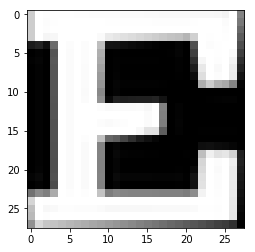

Predicted character: E
Actual label: E


In [26]:
spot_check()